### Imports

In [ ]:
!pip install diffusers["torch"] transformers
!pip install torchvision
!pip install matplotlib

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
from torchvision import transforms, utils
from diffusers import UNet2DModel
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
isTrain = False

### VAE Implementation 
We're going to try and implement a working VAE without the adverserial approach. The theory behind it is mostly the same, but the loss function does not include any adverserial terms.

### Architecture
This time we tried a bigger latent dimension of 256, to try and capture the image better. We kept the amount of 3 downblocks, but added normalization to each block, and more filters compared to the previous implementation.

In [6]:
class TinyVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        #Output Size = (Input Size - Kernel Size + 2 * Padding) / Stride + 1.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), # 32x32 -> 16x16
            nn.GroupNorm(32, 64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16x16 -> 8x8
            nn.GroupNorm(32, 128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8x8 -> 4x4
            nn.GroupNorm(32, 256),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.mean = nn.Linear(256*4*4,latent_dim)
        self.logvar = nn.Linear(256*4*4,latent_dim)
        nn.init.constant_(self.logvar.bias, -4.0)

        self.z_proj = nn.Linear(latent_dim, 256 * 4 * 4)


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1), 
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.GroupNorm(32, 128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.GroupNorm(32, 64),
            nn.ReLU(),
            nn.Conv2d(64, in_channels, kernel_size=3, padding=1),
            nn.Tanh() # value between -1 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self,x):
        latent = self.encoder(x)
        latent_flat = self.flatten(latent)
        logvar = self.logvar(latent_flat)
        mean = self.mean(latent_flat)
        return mean,logvar

    def decode(self,latent):
        x = self.z_proj(latent).view(-1, 256, 4, 4)
        img = self.decoder(x)
        return img

    def forward(self,x):
        mean,logvar = self.encode(x)
        z = self.reparameterize(mean,logvar)
        x_hat = self.decode(z)

        return x_hat,mean,logvar

    def reconstruction_loss(self,x_hat,x):
         return F.mse_loss(x_hat, x, reduction='mean')

    def kl_divergence_loss(self, mean, logvar):
        return 0.5 * (mean.pow(2) + logvar.exp() - 1 - logvar).sum(dim=1).mean()

    def vector_to_feature(self, z_vec):
        return self.z_proj(z_vec).view(-1, 256, 4, 4)          

    def feature_to_image(self, z_feat):
        return self.decoder(z_feat)                            


### Training + Gamma regularization for KL term
We linearly ramp a “capacity” C from 0 up to a maximum (10 nats) over 20 epochs, then at each step we apply a heavy penalty (γ = 150) on the gap (C – KL) whenever KL < C (and drop γ to 0 once KL ≥ C), so that the model is forced to use exactly that much latent information—it gently pushes KL up to the current budget and then stops penalizing, helping avoid posterior collapse and control information flow in the VAE.

A nat is simply an information‐theoretic unit based on the natural logarithm: one nat is the amount of information you gain when an event of probability 1/e occurs, and in general the self‑information of an event with probability p is −ln p nats. In more familiar “bit” units, 1 nat ≃ 1.44 bits.

In [7]:
def train_epoch(model,dataloader,opt_ae, device, epoch):
    model.train()
    total_ae_loss = 0
    loop = tqdm(dataloader,desc='Training...', leave=True)

    for x, _ in loop:
        x = x.to(device)

        # Forward pass
        x_hat, mu, logvar = model(x)

        recon_loss = model.reconstruction_loss(x_hat,x)
        kl_loss = model.kl_divergence_loss(mu, logvar)

        C_max = 10.0          # aim for 10 nats by the end
        C_inc = C_max / 20    # reach it in 20 epochs
        C     = min(C_max, epoch * C_inc)

        gamma = 150.0         
        if kl_loss > C - 0.1:      
            gamma = 0.0
        loss  = recon_loss + gamma * torch.clamp(C - kl_loss, min=0)
        opt_ae.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt_ae.step()

        total_ae_loss += loss.item()

        with torch.no_grad():
            mu_abs  = mu.abs().mean().item()
            logvar_mean = logvar.mean().item()

        loop.set_postfix(
            recon = f'{recon_loss:.4f}',
            kl    = f'{kl_loss:.4f}',
            μ   = f'{mu_abs:.4f}',
            logσ2 = f'{logvar_mean:.4f}',
)
    return total_ae_loss / len(dataloader)

In [8]:
def plot_ae_loss(train_losses):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, marker='o', label='AE Loss')
    plt.title('Autoencoder Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average AE Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Preparing the dataset once again

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),         # 50% chance to flip left-right
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),            # Normalize RGB channels to [-1, 1]
                         (0.5, 0.5, 0.5))
])

In [11]:
from torchvision.datasets import CIFAR100

train_dataset = CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

#### Training Parameters

In [12]:
device = "cuda"
model = TinyVAE()
model.to(device=device)

opt_ae = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 60
ae_losses = []


#### Training

In [ ]:
if isTrain:
    for epoch in range(1, epochs+1):
        print(f"[in epoch {epoch}/{epochs}]")
        ae_loss = train_epoch(model, dataloader, opt_ae, device, epoch - 1)
        ae_losses.append(ae_loss)
        print(f"[{epoch:02d}] VAE Loss: {ae_loss:.4f}")


[in epoch 1/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 82.72it/s, kl=5491.1699, logσ2=-15.0909, recon=0.0460, μ=4.1210]      


[01] VAE Loss: 0.0829
[in epoch 2/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 84.14it/s, kl=6225.1943, logσ2=-16.7210, recon=0.0294, μ=4.2835] 


[02] VAE Loss: 0.0345
[in epoch 3/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 85.35it/s, kl=7065.9946, logσ2=-17.9580, recon=0.0193, μ=4.6893] 


[03] VAE Loss: 0.0249
[in epoch 4/60]


Training...: 100%|██████████| 1563/1563 [00:28<00:00, 54.51it/s, kl=6986.3999, logσ2=-18.7842, recon=0.0172, μ=4.5287]


[04] VAE Loss: 0.0208
[in epoch 5/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.84it/s, kl=7396.0215, logσ2=-19.2173, recon=0.0178, μ=4.6396]


[05] VAE Loss: 0.0185
[in epoch 6/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.98it/s, kl=7905.6460, logσ2=-19.4557, recon=0.0143, μ=4.8627]


[06] VAE Loss: 0.0166
[in epoch 7/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.42it/s, kl=8376.3125, logσ2=-19.5902, recon=0.0136, μ=4.8721]


[07] VAE Loss: 0.0153
[in epoch 8/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.86it/s, kl=8480.4990, logσ2=-19.8230, recon=0.0135, μ=4.8781]


[08] VAE Loss: 0.0142
[in epoch 9/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.32it/s, kl=8056.1064, logσ2=-19.7156, recon=0.0136, μ=4.7197]


[09] VAE Loss: 0.0133
[in epoch 10/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.38it/s, kl=8563.9287, logσ2=-19.6467, recon=0.0090, μ=4.9079]


[10] VAE Loss: 0.0126
[in epoch 11/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.74it/s, kl=8473.7637, logσ2=-19.9630, recon=0.0125, μ=4.9882]


[11] VAE Loss: 0.0119
[in epoch 12/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.49it/s, kl=8685.7852, logσ2=-19.7660, recon=0.0122, μ=5.0747]


[12] VAE Loss: 0.0114
[in epoch 13/60]


Training...: 100%|██████████| 1563/1563 [00:19<00:00, 79.98it/s, kl=9174.7754, logσ2=-19.5703, recon=0.0093, μ=5.2157] 


[13] VAE Loss: 0.0109
[in epoch 14/60]


Training...: 100%|██████████| 1563/1563 [00:23<00:00, 66.70it/s, kl=9552.8828, logσ2=-19.5314, recon=0.0100, μ=5.2617]


[14] VAE Loss: 0.0106
[in epoch 15/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.85it/s, kl=9649.6309, logσ2=-19.6573, recon=0.0100, μ=5.1287]


[15] VAE Loss: 0.0103
[in epoch 16/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 52.08it/s, kl=9666.5156, logσ2=-19.8240, recon=0.0102, μ=5.3448]


[16] VAE Loss: 0.0101
[in epoch 17/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.65it/s, kl=9485.2695, logσ2=-20.0126, recon=0.0103, μ=5.3810] 


[17] VAE Loss: 0.0099
[in epoch 18/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.36it/s, kl=9689.4531, logσ2=-19.8068, recon=0.0087, μ=5.2729] 


[18] VAE Loss: 0.0097
[in epoch 19/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.31it/s, kl=9832.2285, logσ2=-19.7388, recon=0.0109, μ=5.4146] 


[19] VAE Loss: 0.0095
[in epoch 20/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.41it/s, kl=10193.4795, logσ2=-19.7355, recon=0.0086, μ=5.4867]


[20] VAE Loss: 0.0094
[in epoch 21/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.49it/s, kl=9972.1660, logσ2=-19.6532, recon=0.0105, μ=5.4690] 


[21] VAE Loss: 0.0092
[in epoch 22/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.95it/s, kl=10721.0693, logσ2=-19.5631, recon=0.0068, μ=5.5659]


[22] VAE Loss: 0.0091
[in epoch 23/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 82.32it/s, kl=11107.8594, logσ2=-19.3245, recon=0.0097, μ=5.6341] 


[23] VAE Loss: 0.0090
[in epoch 24/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 84.70it/s, kl=10778.0693, logσ2=-19.6222, recon=0.0086, μ=5.6766] 


[24] VAE Loss: 0.0089
[in epoch 25/60]


Training...: 100%|██████████| 1563/1563 [00:27<00:00, 55.93it/s, kl=10853.6387, logσ2=-19.5886, recon=0.0113, μ=5.7478]


[25] VAE Loss: 0.0088
[in epoch 26/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.15it/s, kl=10771.7344, logσ2=-19.8064, recon=0.0094, μ=5.6548]


[26] VAE Loss: 0.0088
[in epoch 27/60]


Training...: 100%|██████████| 1563/1563 [00:26<00:00, 60.00it/s, kl=10933.7383, logσ2=-19.8214, recon=0.0092, μ=5.7808] 


[27] VAE Loss: 0.0087
[in epoch 28/60]


Training...: 100%|██████████| 1563/1563 [00:23<00:00, 66.36it/s, kl=11268.2539, logσ2=-19.6716, recon=0.0083, μ=5.8866]


[28] VAE Loss: 0.0086
[in epoch 29/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.43it/s, kl=11526.1855, logσ2=-19.5109, recon=0.0081, μ=5.8441]


[29] VAE Loss: 0.0085
[in epoch 30/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 52.00it/s, kl=11719.9062, logσ2=-19.8094, recon=0.0108, μ=6.1225]


[30] VAE Loss: 0.0085
[in epoch 31/60]


Training...: 100%|██████████| 1563/1563 [00:25<00:00, 60.71it/s, kl=11908.2803, logσ2=-19.5654, recon=0.0096, μ=6.1498] 


[31] VAE Loss: 0.0084
[in epoch 32/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 83.32it/s, kl=11920.2637, logσ2=-19.7875, recon=0.0080, μ=6.0187] 


[32] VAE Loss: 0.0084
[in epoch 33/60]


Training...: 100%|██████████| 1563/1563 [00:25<00:00, 61.22it/s, kl=12154.9824, logσ2=-19.6302, recon=0.0080, μ=6.1447]


[33] VAE Loss: 0.0083
[in epoch 34/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.43it/s, kl=12465.4414, logσ2=-19.3526, recon=0.0067, μ=6.0610]


[34] VAE Loss: 0.0083
[in epoch 35/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.14it/s, kl=12067.3672, logσ2=-19.5436, recon=0.0073, μ=6.0106]


[35] VAE Loss: 0.0082
[in epoch 36/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.26it/s, kl=12565.7783, logσ2=-19.5905, recon=0.0112, μ=6.4555]


[36] VAE Loss: 0.0082
[in epoch 37/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.33it/s, kl=12705.7852, logσ2=-19.2794, recon=0.0078, μ=6.3504]


[37] VAE Loss: 0.0082
[in epoch 38/60]


Training...: 100%|██████████| 1563/1563 [00:25<00:00, 61.96it/s, kl=12904.4736, logσ2=-19.5689, recon=0.0080, μ=6.4350] 


[38] VAE Loss: 0.0081
[in epoch 39/60]


Training...: 100%|██████████| 1563/1563 [00:28<00:00, 55.65it/s, kl=12548.4395, logσ2=-19.6835, recon=0.0085, μ=6.4860]


[39] VAE Loss: 0.0081
[in epoch 40/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.34it/s, kl=13009.3379, logσ2=-19.3428, recon=0.0092, μ=6.3649]


[40] VAE Loss: 0.0080
[in epoch 41/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.33it/s, kl=13304.3613, logσ2=-19.3603, recon=0.0074, μ=6.4699]


[41] VAE Loss: 0.0080
[in epoch 42/60]


Training...: 100%|██████████| 1563/1563 [00:19<00:00, 80.99it/s, kl=13478.0996, logσ2=-19.0565, recon=0.0079, μ=6.5085] 


[42] VAE Loss: 0.0080
[in epoch 43/60]


Training...: 100%|██████████| 1563/1563 [00:25<00:00, 61.87it/s, kl=13535.3779, logσ2=-19.3991, recon=0.0062, μ=6.5480]


[43] VAE Loss: 0.0079
[in epoch 44/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.21it/s, kl=14021.6777, logσ2=-19.0799, recon=0.0065, μ=6.7414]


[44] VAE Loss: 0.0079
[in epoch 45/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.61it/s, kl=13877.7578, logσ2=-19.1131, recon=0.0078, μ=6.5496]


[45] VAE Loss: 0.0079
[in epoch 46/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.24it/s, kl=14402.8184, logσ2=-19.2855, recon=0.0092, μ=6.7939]


[46] VAE Loss: 0.0078
[in epoch 47/60]


Training...: 100%|██████████| 1563/1563 [00:24<00:00, 63.23it/s, kl=14573.3164, logσ2=-19.0526, recon=0.0069, μ=6.6912] 


[47] VAE Loss: 0.0078
[in epoch 48/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 84.92it/s, kl=14553.8330, logσ2=-19.3486, recon=0.0080, μ=6.9362] 


[48] VAE Loss: 0.0078
[in epoch 49/60]


Training...: 100%|██████████| 1563/1563 [00:28<00:00, 54.92it/s, kl=15065.2148, logσ2=-19.4582, recon=0.0094, μ=7.0995]


[49] VAE Loss: 0.0078
[in epoch 50/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.77it/s, kl=14538.6250, logσ2=-19.2800, recon=0.0085, μ=7.0475]


[50] VAE Loss: 0.0077
[in epoch 51/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 52.04it/s, kl=15222.1699, logσ2=-19.2534, recon=0.0065, μ=6.9458]


[51] VAE Loss: 0.0077
[in epoch 52/60]


Training...: 100%|██████████| 1563/1563 [00:25<00:00, 60.97it/s, kl=15364.3574, logσ2=-19.3226, recon=0.0080, μ=7.2728]


[52] VAE Loss: 0.0077
[in epoch 53/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.93it/s, kl=15229.5020, logσ2=-19.1721, recon=0.0081, μ=7.2220]


[53] VAE Loss: 0.0077
[in epoch 54/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.53it/s, kl=15212.7383, logσ2=-19.0509, recon=0.0065, μ=6.9991]


[54] VAE Loss: 0.0076
[in epoch 55/60]


Training...: 100%|██████████| 1563/1563 [00:29<00:00, 52.15it/s, kl=15384.1768, logσ2=-19.0026, recon=0.0069, μ=7.1055]


[55] VAE Loss: 0.0076
[in epoch 56/60]


Training...: 100%|██████████| 1563/1563 [00:22<00:00, 70.99it/s, kl=16186.3340, logσ2=-18.9301, recon=0.0088, μ=7.2621] 


[56] VAE Loss: 0.0076
[in epoch 57/60]


Training...: 100%|██████████| 1563/1563 [00:28<00:00, 54.54it/s, kl=16024.7256, logσ2=-19.0578, recon=0.0073, μ=7.1563]


[57] VAE Loss: 0.0076
[in epoch 58/60]


Training...: 100%|██████████| 1563/1563 [00:30<00:00, 51.40it/s, kl=16402.4102, logσ2=-18.8178, recon=0.0071, μ=7.2460]


[58] VAE Loss: 0.0076
[in epoch 59/60]


Training...: 100%|██████████| 1563/1563 [00:23<00:00, 66.48it/s, kl=16410.6445, logσ2=-19.1390, recon=0.0077, μ=7.3205] 


[59] VAE Loss: 0.0076
[in epoch 60/60]


Training...: 100%|██████████| 1563/1563 [00:18<00:00, 84.85it/s, kl=16389.6074, logσ2=-19.0830, recon=0.0083, μ=7.4848] 

[60] VAE Loss: 0.0075


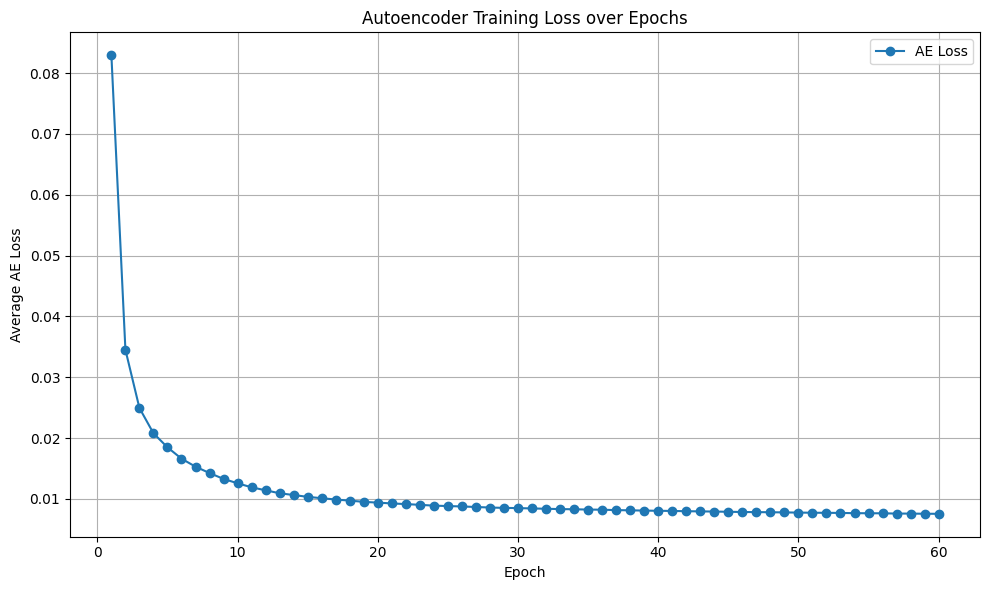

In [72]:
plot_ae_loss(ae_losses)

In [13]:
def show_reconstruction(model, dataset, device):
    model.eval()  # encoder & decoder both fine in eval when using GroupNorm

    # inverse of Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    denorm = lambda t: t * 0.5 + 0.5   # [-1,1] → [0,1]

    # pick a random CIFAR‑sample
    idx = torch.randint(0, len(dataset), ()).item()
    x, _ = dataset[idx]          # tensor in [-1,1]
    x = x.unsqueeze(0).to(device)

    with torch.no_grad():
        x_hat, _, _ = model(x)   # forward pass

    # prepare for display
    x_vis     = denorm(x.squeeze().cpu())       # (C,H,W) → [0,1]
    x_hat_vis = denorm(x_hat.squeeze().cpu())

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(x_vis.permute(1, 2, 0));     ax[0].set_title('Original');       ax[0].axis('off')
    ax[1].imshow(x_hat_vis.permute(1, 2, 0)); ax[1].set_title('Reconstruction'); ax[1].axis('off')
    plt.tight_layout();  plt.show()

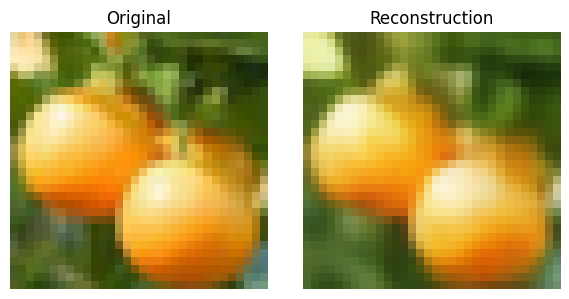

In [17]:
if not isTrain:
    checkpoint = torch.load("./checkpoints/vae_e060.pt")
    model.load_state_dict(checkpoint['model_state'])

show_reconstruction(model, train_dataset, device)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    ckpt = {
        "epoch": epoch,                 
        "loss" : loss,                  
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(ckpt, path)

if isTrain:
    save_checkpoint(model, opt_ae, 60, ae_losses[59], path=f"checkpoints/vae_e{epoch:03d}.pt")

### VAE Conclusion
In the end, we're happy to get some pretty good results!
We will now attempt to once again implement the full latent diffusion process, using our own VAE.


### Implementing Latent Diffusion using our TinyVAE and UNet2DModel

#### Load the VAE model

In [ ]:
vae_weights_path = "./checkpoints/vae_e060.pt"

checkpoint = torch.load(vae_weights_path)
model.load_state_dict(checkpoint['model_state'])

#### UNet model
We once again use hugging face's UNet2DModel to quickly test our VAE model. We aim to also implement our own UNet in the following chapters.
We also make sure that the UNet's input matches our latent space (256 -> 256x4x4)

In [50]:
unet = UNet2DModel(
    in_channels=256,
    out_channels=256,
    sample_size=4,
    block_out_channels = (256,512),
    down_block_types=("DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D"),
)
unet.to('cuda')
unet.enable_gradient_checkpointing()

#### Diffusion Process
This is the same model we used in part 1. The only difference is that we had to match our TinyVAE in inference and training by using the "feature_to_image" and "vector_to_feature" functions of our model to correctly use the latent space in terms of sizing.

In [ ]:
class LatentDiffusion(nn.Module):
    def __init__(self, vae: TinyVAE, unet: UNet2DModel,
                 timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda', scaling_factor=1):
        super().__init__()
        self.vae = vae
        self.vae.eval()                
        for p in self.vae.parameters(): # Freeze VAE
            p.requires_grad_(False)
        self.unet = unet
        self.timesteps = timesteps
        self.device = device
        self.scaling_factor = scaling_factor
        # linear noise timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", 1. - betas)
        self.register_buffer("alpha_hat", torch.cumprod(1. - betas, dim=0))
        self.register_buffer("sigmas", torch.sqrt(betas))

In [52]:
def q_sample(self, z0, t):
    noise = torch.randn_like(z0)
    mean = self.alpha_hat[t].sqrt().view(-1,1,1,1) * z0
    deviation = (1 - self.alpha_hat[t]).sqrt().view(-1,1,1,1)
    return mean + deviation*noise, noise

LatentDiffusion.q_sample = q_sample

In [53]:
def loss(self, imgs, t):
    with torch.no_grad():
        mu, logvar = self.vae.encode(imgs)                     
        z_vec = self.vae.reparameterize(mu, logvar)            
        z_feat = self.vae.vector_to_feature(z_vec)             
        z_feat = z_feat * self.scaling_factor                  

    z_t, noise = self.q_sample(z_feat, t)                      
    noise_pred = self.unet(z_t, t).sample                      
    return F.mse_loss(noise_pred, noise)


LatentDiffusion.loss = loss

In [54]:
def forward(self, imgs):
        batch = imgs.size(0)
        t = torch.randint(0, self.timesteps, (batch,), device=self.device)
        return self.loss(imgs, t)   

LatentDiffusion.forward = forward

In [ ]:
@torch.no_grad()
def generate(self, batch_size=1):
    z = torch.randn(batch_size,
                    self.unet.in_channels,
                    self.unet.sample_size,
                    self.unet.sample_size,
                    device=self.device)                        

    for i in reversed(range(self.timesteps)):
        t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

        noise_pred = self.unet(z, t).sample
        alpha_t     = self.alphas[t].view(-1,1,1,1)
        alpha_hat_t = self.alpha_hat[t].view(-1,1,1,1)
        sigma_t     = self.sigmas[t].view(-1,1,1,1)

        z = (z - ((1 - alpha_t) / (1 - alpha_hat_t).sqrt()) * noise_pred)
        z = z / alpha_t.sqrt()
        if i > 0:
            z += sigma_t * torch.randn_like(z)

    imgs = self.vae.feature_to_image(z / self.scaling_factor)  
    imgs = (imgs.clamp(-1, 1) + 1) / 2                        
    return imgs


LatentDiffusion.generate = generate

In [ ]:
def save_ckpt(path, model, optimizer, scaler, scheduler, epoch):
    ckpt = {
        "epoch": epoch,
        "model": model.state_dict(),       
        "optim": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
        "sched": scheduler.state_dict(),
    }
    torch.save(ckpt, path)
    print(f"✅  saved checkpoint to {path} (epoch {epoch})")


In [ ]:
def load_ckpt(path, model, optimizer, scaler, scheduler, map_loc="cuda"):
    ckpt = torch.load(path, map_location=map_loc)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optim"])
    scaler.load_state_dict(ckpt["scaler"])
    scheduler.load_state_dict(ckpt["sched"])
    print(f"✅ resumed from {path} (epoch {ckpt['epoch']})")
    return ckpt["epoch"]

#### Training
We train the model for 100 epochs, using the same training loop as before, but this time we also save checkpoints.

In [ ]:
def train(model,
          dataloader,
          optimizer,
          scaler,
          scheduler,
          start_epoch=0,
          epochs=10,
          ckpt_dir="ckpts"):

    model.train()
    global_step = scheduler.last_epoch + 1

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        loop = tqdm(dataloader,
                    desc=f"Epoch {epoch+1}",
                    leave=False)
        for imgs, _ in loop:
            imgs = imgs.to(model.device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", dtype=torch.float16):
                loss = model(imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()
            loop.set_postfix(loss=f"{loss.item():.4f}")

        avg = total_loss / len(dataloader)
        print(f"ep {epoch+1:03d} | avg loss {avg:.4f}")

        save_ckpt(f"{ckpt_dir}/diff_e{epoch+1:03d}.pt",
                  model, optimizer, scaler, scheduler, epoch+1)

In [ ]:
diffusion = LatentDiffusion(model, unet, timesteps=1000, scaling_factor=0.18215)
diffusion.to('cuda')

opt = torch.optim.Adam(diffusion.unet.parameters(), lr=9e-5)
scaler = GradScaler()
train(diffusion, dataloader, opt, scaler, start_epoch=0, epochs=100)

We actually lost our training data, but we got very slow recreation loss descent, which made us believe more training would be helpful.
These were our samples:
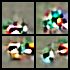

#### More training

In [ ]:
start = load_ckpt("ckpts/diff_e010.pt", diff, opt, scaler)
train(diff, dataloader, opt, scaler,
      start_epoch=start, epochs=20)

We lost the data for this one too..

### Conclusion part 2
Even with more training, we couldn't really get much better results, as we can see from this sampling:<br>
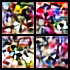